# 2018-10-02 - Scraping, récupérer une image depuis LeMonde

Le notebook suivant récupère le contenu d'une page du journal [Le Monde](https://www.lemonde.f), extrait les urls d'images à l'aide d'une expression régulière puis télécharge les images pour les stocker dans un répertoire. Le notebook extrait les images d'une personnalité.

Première étape, on récupère automatiquement le contenu d'une page.

In [1]:
%matplotlib inline

In [2]:
import urllib.request as ulib

def get_html(source):
    with ulib.urlopen(source) as u:
        return u.read()

page = get_html("https://www.lemonde.fr")
page[:500]

b'         <!DOCTYPE html> <html lang="fr" prefix="og: http://ogp.me/ns#"> <head> <meta charset="UTF-8"> <meta http-equiv="X-UA-Compatible" content="IE=edge"> <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no"> <link rel="manifest" href="/manifest.json"> <script>\nif(sessionStorage.fontsFirst&&sessionStorage.fontsLast&&\'fonts\'in document){document.documentElement.classList.add(\'fonts-loaded\');}\nif(typeof Promise===\'undefined\'){document.documentElement.classList.ad'

Quelques expériences avec les encoding. La norme sur internet est l'encoding [utf-8](https://fr.wikipedia.org/wiki/UTF-8). Un caractère ne peut représenter que 255 caractères distincts ce qui est insuffisant pour certaines langues. L'encoding est un ensemble de codes qui permettent de représenter des caractères complexes avec une séquence d'octets.

In [3]:
ch = "é"
ch

'é'

In [4]:
ch.encode("utf-8")

b'\xc3\xa9'

Quand on essaye d'encoder et décoder avec des encodings différents, cela a peu de chance de fonctionner.

In [5]:
try:
    ch.encode("utf-8").decode("ascii")
except UnicodeDecodeError as e:
    print(e)

'ascii' codec can't decode byte 0xc3 in position 0: ordinal not in range(128)


On revient sur la page du monde.

In [6]:
page2 = page.decode("utf-8")

In [7]:
page2[:500]

'         <!DOCTYPE html> <html lang="fr" prefix="og: http://ogp.me/ns#"> <head> <meta charset="UTF-8"> <meta http-equiv="X-UA-Compatible" content="IE=edge"> <meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no"> <link rel="manifest" href="/manifest.json"> <script>\nif(sessionStorage.fontsFirst&&sessionStorage.fontsLast&&\'fonts\'in document){document.documentElement.classList.add(\'fonts-loaded\');}\nif(typeof Promise===\'undefined\'){document.documentElement.classList.ad'

In [8]:
len(page)

162301

On cherche les urls d'images [JPEG](https://fr.wikipedia.org/wiki/JPEG), quelque chose comme ``<img ... src="...jpg" ... />``.

In [9]:
import re
reg = re.compile('src="(.*?[.]jpg)"')

In [10]:
images = reg.findall(page2)
images[:5]

['https://img.lemde.fr/2018/12/29/0/80/2533/1689/450/0/60/0/9d50bd3_TBNJ2jfeDAMcrJTRCJo_PhcJ.jpg',
 'https://img.lemde.fr/2018/12/29/0/80/2533/1689/600/0/60/0/9d50bd3_TBNJ2jfeDAMcrJTRCJo_PhcJ.jpg',
 'https://img.lemde.fr/2018/12/28/0/2/2995/1997/450/0/60/0/af7bb7f_0Kn4ov2yDlsRVB4pN4XY788n.jpg',
 'https://img.lemde.fr/2018/12/28/0/2/2995/1997/600/0/60/0/af7bb7f_0Kn4ov2yDlsRVB4pN4XY788n.jpg',
 'https://img.lemde.fr/2018/12/28/161/0/2933/1955/450/0/60/0/b24bb7e_e54b795931204bc49ec9db07b61096fc-e54b795931204bc49ec9db07b61096fc-0.jpg']

In [11]:
import os
if not os.path.exists("images/lemonde2"):
    os.makedirs("images/lemonde2")

Et on enregistre les images.

In [12]:
for i, img in enumerate(images):
    nom = img.split("/")[-1]
    dest = os.path.join("images/lemonde2", nom)
    if os.path.exists(dest):
        continue
    
    try:
        contenu = get_html(img)
    except Exception as e:
        print(e)
        continue
    print(f"{i+1}/{len(images)}: {nom}")
    with open(dest, "wb") as f:
        f.write(contenu)

79/126: 7cda9b0_HJabMp9DiCtOQAD8os3AxvJa.jpg
81/126: 64dba25_87ec32b73a934148a1f5a5591ef926b0-87ec32b73a934148a1f5a5591ef926b0-0.jpg
unknown url type: '/dist/assets/img/group/lux-residence-3.png" alt="">  </a> </div>   <div class="bd__bloc bd__bloc--image " data-partner="gymglish"> <a href="https://anglais.lemonde.fr/">  <img data-src="/dist/assets/img/group/gymglish-4.png" alt="">  </a> </div>   <div class="bd__bloc bd__bloc--visible-mobile" data-partner="cuponation"> <div class="bd__header"> <span>Codes promos</span> <span>avec Global Savings Group</span> </div> <div class="bd__content bd__content--classic"> <ul>  <li><a href="https://codepromo.lemonde.fr/code-promo-amazon">Amazon Prime à 5,99€ par mois</a></li>  <li><a href="https://codepromo.lemonde.fr/code-promo-asos">-10% pour les édutiants avec Asos</a></li>  <li><a href="https://codepromo.lemonde.fr/code-promo-fnac">Fnac : envoi offert dès 25€</a></li>  <li><a href="https://codepromo.lemonde.fr/code-promo-showroomprive">Showroo

Affichons quelques images.

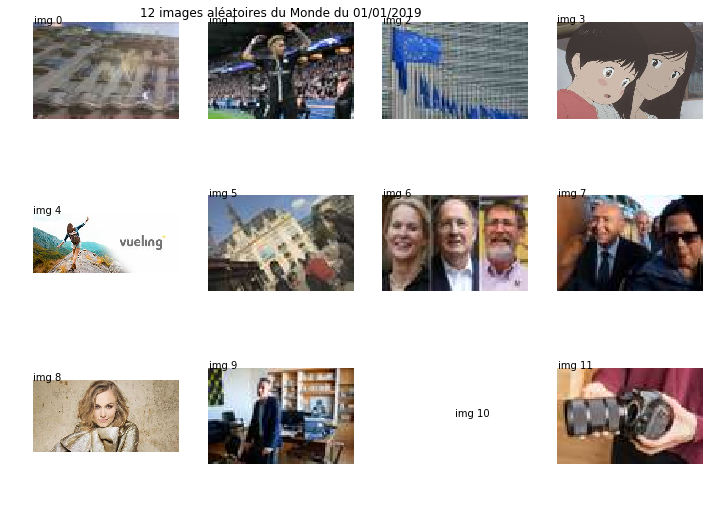

In [13]:
from mlinsights.plotting import plot_gallery_images
import numpy
from datetime import datetime
now = datetime.now().strftime("%d/%m/%Y")
fold = "images/lemonde2"
imgs = [os.path.join(fold, img) for img in os.listdir(fold)]
choices = numpy.random.choice(len(imgs), 12)
random_set = [imgs[i] for i in choices]
ax = plot_gallery_images(random_set)
ax[0, 1].set_title("12 images aléatoires du Monde du %s" % now);

On se concentre sur d'une personnalité en utilisant la légende de l'image. On utilise une expression régulière pour récupérer toutes les images.

In [14]:
import re
reg = re.compile('<img src=\\"([^>]+?[.]jpg)\\" alt=\\"([^>]*?)\\">', re.IGNORECASE)

In [15]:
len(page2)

160804

In [16]:
imgs = reg.findall(page2)
len(imgs), imgs[:3]

(65,
 [('https://img.lemde.fr/2018/12/29/0/80/2533/1689/600/0/60/0/9d50bd3_TBNJ2jfeDAMcrJTRCJo_PhcJ.jpg',
   ''),
  ('https://img.lemde.fr/2018/12/28/0/2/2995/1997/600/0/60/0/af7bb7f_0Kn4ov2yDlsRVB4pN4XY788n.jpg',
   ''),
  ('https://img.lemde.fr/2018/12/28/161/0/2933/1955/600/0/60/0/b24bb7e_e54b795931204bc49ec9db07b61096fc-e54b795931204bc49ec9db07b61096fc-0.jpg',
   '')])

In [17]:
if not os.path.exists("images/personne"):
    os.makedirs("images/personne")

In [18]:
with open(os.path.join("images/personne", "legend.txt"), "w") as fl:

    for img, alt in imgs:
        if alt == "":
            continue
        nom = img.split("/")[-1]
        dest = os.path.join("images/personne", nom)
        if os.path.exists(dest):
            continue

        try:
            contenu = get_html(img)
        except Exception as e:
            print(e)
            continue
        print(nom)
        with open(dest, "wb") as f:
            f.write(contenu)
        fl.write("{0};{1}\n".format(nom, alt))

3d0d45c_JHknkYmikIzxujYaYUwCwObB.jpg
6a3748b_8060-1khmzd6.jpg
369c0c6_UfCKP8sGIrOaYytCKHPMiZnB.jpg
545cf15_4ukakb_S88U7e7KZ_fu6nwps.jpg
64dba25_87ec32b73a934148a1f5a5591ef926b0-87ec32b73a934148a1f5a5591ef926b0-0.jpg


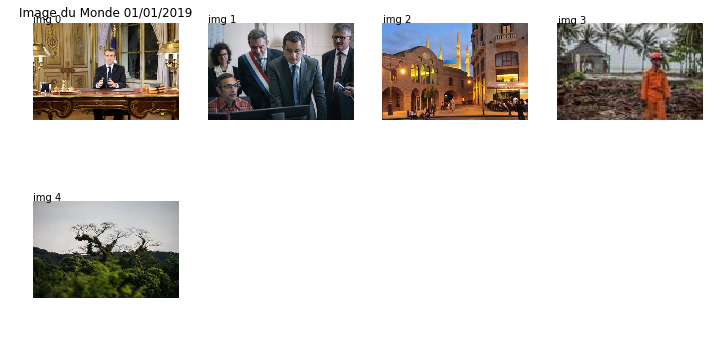

In [19]:
now = datetime.now().strftime("%d/%m/%Y")
fold = "images/personne"
imgs = [os.path.join(fold, img) for img in os.listdir(fold) if ".jpg" in img]
ax = plot_gallery_images(imgs)
if len(ax) > 0:
    # Si on a trouvé des images.
    if len(ax.shape) == 2:
        ax[0, 0].set_title("Image du Monde %s" % now)        
    else:
        ax[0].set_title("Image du Monde %s" % now)
ax;